In [1]:
import os
import pandas
from PIL import Image 
from IPython.display import display as IPythonDisplay
import keras
from keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
from keras.layers import Conv2D,BatchNormalization,Dropout,MaxPooling2D,Dense,Flatten,Activation,ZeroPadding2D,AveragePooling2D
from keras.optimizers import Adam, SGD,Adagrad
from keras.models import load_model

import matplotlib.pyplot as pyplot
import seaborn 
import sklearn.metrics 
import numpy
from keras.utils import plot_model



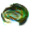

(32, 32)


In [2]:
#get the base_path where all the data is 
base_path=os.path.abspath('./')
train_folder_name='train'
test_folder_name='test'
validation_folder_name='validation'
#base path and names of different folders with data
for base_directory, folders , files in os.walk(os.path.join(base_path,train_folder_name)):
    for file in files:
        first_image=Image.open(os.path.join(base_directory, file))
        IPythonDisplay(first_image)
        size_of_images=first_image.size
        
        break
print(size_of_images)
#we take the first image from the train file and determine its size, that we will need to use later


In [3]:
generator_train_data=KerasImageDataGenerator(rescale=1.0/255.0)
# i have tried numerous data augmentation strategies on the generator_train_data to see if it improves the accuracy 
#on the validation/the ability to generalize, but my attempts just led
#to a worse final score on the train and validation, so I didn't include data agumentation in the final model
#i split the data by 255 for faster convergence of the model
#I did the same for the validation data
generator_validation_data=KerasImageDataGenerator(rescale=1.0/255.0)


#the column names of the files where the labels of each train/validation picture are mentioned
column_names=['FileName','Label']

train_labels=os.path.join(base_path,'train.txt')
validation_labels=os.path.join(base_path,'validation.txt')

#save these as variables since we need them further
nr_train_images=sum(1 for newLine in open(train_labels))
nr_validation_images=sum(1 for newLine in open(validation_labels))


#we make two data frames one for train images and one for validation images labels so we can use this further, knowing what the true label of each image is
#here we just creeate the dataframes
train_labels_data_frame=pandas.DataFrame(columns=column_names, index=range(0,nr_train_images ))

validation_labels_data_frame=pandas.DataFrame(columns=column_names, index=range(0, nr_validation_images))


In [4]:
for line_index, line_content in enumerate(open(train_labels)):
    #take out end line character from rows
    line_content=line_content.rstrip('\n')
    #FileName is before the , so it is loaded first and Label is after the , so it is loaded to Label, the second part of the split string
    train_labels_data_frame.loc[line_index].FileName,  train_labels_data_frame.loc[line_index].Label =line_content.split(',')

  
    
for line_index, line_content in enumerate(open(validation_labels)):
    line_content=line_content.rstrip('\n')
    validation_labels_data_frame.loc[line_index].FileName, validation_labels_data_frame.loc[line_index].Label=line_content.split(',')

#now we have the data frame with all the image names and labels
validation_labels_data_frame

,FileName,Label
0,030001.png,3
1,030002.png,0
2,030003.png,7
3,030004.png,7
4,030005.png,4
...,...,...
4995,034996.png,6
4996,034997.png,1
4997,034998.png,7
4998,034999.png,4


In [5]:
# class mode is categorical because we have multiple classes
# we choose the batch size of 32 which i determined through tests was the best for convergence to a maximum validation accuracy, 
#I have also tried 64,128,16, with worse results
#for the image size we use the one we have determined from the first images, and I mention they are "rgb" and also the colum which denotes 
#the FileName as x_col and the Label as y_col
train_batch=32
train_data_flow=generator_train_data.flow_from_dataframe(
        class_mode="categorical",
        x_col=column_names[0],
        y_col=column_names[1],
        dataframe=train_labels_data_frame,
        directory=os.path.join(base_path,train_folder_name),
        target_size=size_of_images,
        color_mode="rgb",
        batch_size=train_batch,
        seed=19

)

validation_data_flow=generator_validation_data.flow_from_dataframe(
        class_mode="categorical",
        x_col=column_names[0],
        y_col=column_names[1],
        dataframe=validation_labels_data_frame,
        directory=os.path.join(base_path,validation_folder_name),
        target_size=size_of_images,
        color_mode="rgb",
        batch_size=nr_validation_images,
        seed=19

)
# for validation batch size I used the entire dataset




Found 30001 validated image filenames belonging to 8 classes.
Found 5000 validated image filenames belonging to 8 classes.


In [5]:
#for the test data I set class_mode None because I don't have labels for them and we only specify the directory instead of 
#a column labels and a column with the image that has that label
#the class actually tells Keras where to find the images in what folder from the base_path
test_data_flow = KerasImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    class_mode=None,
    directory=base_path,
    classes=['test'],
    color_mode="rgb",
    target_size=size_of_images,
    batch_size=1,
    shuffle=False
)
validation_data_flow_conf_matrix = KerasImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    class_mode=None,
    directory=base_path,
    classes=['validation'],
    color_mode="rgb",
    target_size=size_of_images,
    batch_size=1,
    shuffle=False
)

#the validation_data_flow_conf_matrix will be used when seeing the accuracy for ensamble of epochs/models

Found 5000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [6]:
#dropout rate for convolutional and dense layers, I found out smaller rates to work better for conv layers
#and higher rates to work better for dense layers
dropout_rate_convolutional=0.25
dropout_rate_dense=0.5

In [7]:
#model 1, the one from which i created my two other variations 
#I named it 4_4 since it has 4 conv layers and 4 dense layers
best_lr_4_4=[0.08,0.05]
best_momentum_4_4=[0,0.6]
#the best learning rate i used for Model1 and the second best_lr that I used for it. the second best one I used in combination with momentum.
#these two saved models are components of the final ensemble.
cnn_sequential_model_4_4 = keras.Sequential()
#I create an instance of a sequential model and start adding layers to it
cnn_sequential_model_4_4.add(Conv2D(128, kernel_size=(3, 3), input_shape=(32,32,3)))
#I apply batchnormalization before activation
cnn_sequential_model_4_4.add(BatchNormalization())
# i use relu as an activation function for all of my layers
cnn_sequential_model_4_4.add(Activation('relu'))
#I use max pooling also as a way to prevent over-fitting-> results were a lot worse without max pooling, as described and shown in the report
cnn_sequential_model_4_4.add(MaxPooling2D(pool_size=(2,2)))
#based on my experiments I found a dropout of 0.25 to be the appropriate rate for convolutional layers
cnn_sequential_model_4_4.add(Dropout(dropout_rate_convolutional))


cnn_sequential_model_4_4.add(Conv2D(128, kernel_size=(3, 3)))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_convolutional))



cnn_sequential_model_4_4.add(Conv2D(256, kernel_size=(2, 2)))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(MaxPooling2D(pool_size=(2, 2)))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_convolutional))





cnn_sequential_model_4_4.add(Conv2D(512, kernel_size=(2, 2)))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_convolutional))

#based on literature and different models I have seen online, the number of filters are in ascending order


#the Flatten layer brings the output of the last convolutional/dropout layer to a form that can be used with the desne layers

cnn_sequential_model_4_4.add(Flatten())

cnn_sequential_model_4_4.add(Dense(1024))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_dense))

cnn_sequential_model_4_4.add(Dense(512))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_dense))

cnn_sequential_model_4_4.add(Dense(256))
cnn_sequential_model_4_4.add(BatchNormalization())
cnn_sequential_model_4_4.add(Activation('relu'))
cnn_sequential_model_4_4.add(Dropout(dropout_rate_dense))

#the number of neurons in the dense layers are in descending order as I have seen used famous models
#i have tried using more layers, adding another layer of 2048 at the beginning or other scenarios with more than 4 dense layers, but they all lead to more overfit,
#a model with less generalization capacity-> as can be seen in the report


cnn_sequential_model_4_4.add(Dense(8))
cnn_sequential_model_4_4.add(Activation('softmax'))
#I use softmax as an activation function to get the values that tell us what probability there is t
#that an image belongs to each class(they add up to 1)

cnn_sequential_model_4_4.summary()
#here I print the summary of the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 128)       5

In [8]:
#Model 2-> this is the Model with which I obtained my best result from a single model-> 
#69.9 % on validation, and 70.025%on the private test, and 69.0 % on the public test set
#this was obtained with 0.10 and no momentum( the [0] from both arrays)
#Model 2 is Model 1 with the 2nd and 3rd convolutional layer and the other associated layers of their group doubled 

best_lr_6_4_stride=[0.10,0.15,0.5]
best_momentum_6_4_stride=[0,0,0.7]
#all these 3 configurations went into my final ensemble

#same as Model 1
cnn_sequential_model_6_4_stride = keras.Sequential()
cnn_sequential_model_6_4_stride.add(Conv2D(128, kernel_size=(3, 3), input_shape=(32,32,3)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(MaxPooling2D(pool_size=(2,2)))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))

#new Convolutional Layer-> as I have seen in different sources, a lot of papers tried using strides for classifying small images
#I tried (2,2), (3,3),(1,2),(2,1) and (1,2) greatly increased the ability of the model whilst reducing overfit
cnn_sequential_model_6_4_stride.add(Conv2D(128, kernel_size=(3, 3),strides=(1,2)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))

cnn_sequential_model_6_4_stride.add(Conv2D(128, kernel_size=(3, 3)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))


cnn_sequential_model_6_4_stride.add(Conv2D(256, kernel_size=(2, 2)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(MaxPooling2D(pool_size=(2, 2)))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))


#this is also a new layer, as previously I use strides (1,2)

cnn_sequential_model_6_4_stride.add(Conv2D(256, kernel_size=(2, 2),strides=(1,2)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))

#I also insert a ZeroPadding2D with pading (1,1) for the image
cnn_sequential_model_6_4_stride.add(ZeroPadding2D(padding=(1,1)))
cnn_sequential_model_6_4_stride.add(Conv2D(512, kernel_size=(2, 2)))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_convolutional))

# the dense layers are identical to Model 1

cnn_sequential_model_6_4_stride.add(Flatten())

cnn_sequential_model_6_4_stride.add(Dense(1024))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_dense))

cnn_sequential_model_6_4_stride.add(Dense(512))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_dense))

cnn_sequential_model_6_4_stride.add(Dense(256))
cnn_sequential_model_6_4_stride.add(BatchNormalization())
cnn_sequential_model_6_4_stride.add(Activation('relu'))
cnn_sequential_model_6_4_stride.add(Dropout(dropout_rate_dense))

cnn_sequential_model_6_4_stride.add(Dense(8))
cnn_sequential_model_6_4_stride.add(Activation('softmax'))

cnn_sequential_model_6_4_stride.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 7, 128)        147584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 7, 128)       

In [9]:
#Model 3-> the last model that I used as part of the ensemble, it is a version of Model 1 with the 2nd and 3rd
#layers doubled but without strides different from (1,1)

best_lr_model_6_4_no_strides=[0.10]
best_momentum_6_4_no_strides=[0]

cnn_sequential_6_4_no_strides = keras.Sequential()
cnn_sequential_6_4_no_strides.add(Conv2D(128, kernel_size=(3, 3), input_shape=(32,32,3)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(MaxPooling2D(pool_size=(2,2)))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))


cnn_sequential_6_4_no_strides.add(Conv2D(128, kernel_size=(3, 3)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))


#the doubled 2nd layer but without strides different than (1,1)
cnn_sequential_6_4_no_strides.add(Conv2D(128, kernel_size=(3, 3)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))

cnn_sequential_6_4_no_strides.add(Conv2D(256, kernel_size=(2, 2)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(MaxPooling2D(pool_size=(2, 2)))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))


#the doubled 3rd layer but without strides different than (1,1)
cnn_sequential_6_4_no_strides.add(Conv2D(256, kernel_size=(2, 2)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(MaxPooling2D(pool_size=(2, 2)))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))

cnn_sequential_6_4_no_strides.add(ZeroPadding2D(padding=(1,1)))
cnn_sequential_6_4_no_strides.add(Conv2D(512, kernel_size=(2, 2)))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_convolutional))



#dense layers are identical as Model 2 and Model 1
cnn_sequential_6_4_no_strides.add(Flatten())

cnn_sequential_6_4_no_strides.add(Dense(1024))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_dense))

cnn_sequential_6_4_no_strides.add(Dense(512))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_dense))

cnn_sequential_6_4_no_strides.add(Dense(256))
cnn_sequential_6_4_no_strides.add(BatchNormalization())
cnn_sequential_6_4_no_strides.add(Activation('relu'))
cnn_sequential_6_4_no_strides.add(Dropout(dropout_rate_dense))



cnn_sequential_6_4_no_strides.add(Dense(8))
cnn_sequential_6_4_no_strides.add(Activation('softmax'))

cnn_sequential_6_4_no_strides.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 30, 128)       512       
_________________________________________________________________
activation_18 (Activation)   (None, 30, 30, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 128)       147584    
_________________________________________________________________
batch_normalization_17 (Batc (None, 13, 13, 128)      

In [10]:
#callbacks that I have used throughout my executions of all the 3 models that went into the ensemble
#we pass the instance of my best individual model, Model 2, and the learning rate that lead to the best result 69.90% val accuracy
model_name="cnn_stride_010_"
monitor_aspect='val_acc'
#learning rate is multiplied with a factor of 0.5 if model stops learning on the validation accuracy for 3 epochs
reduce_on_plateau_callback= ReduceLROnPlateau(monitor=monitor_aspect, factor=0.5, patience=3,verbose=1)
#early stopping callback, stop model afeter 16 epochs have passed with no improvement in val_acc, 
#which is also equivalent to 5 multiplications of 0.5 of learning rate
early_stopping_callback = EarlyStopping(monitor=monitor_aspect, patience=16,verbose=1)
#the best optimizer learning rate combination we could find for Model 2, sgd with 0.10 learning rate and 0 momentum
sgd_optimizer=SGD(best_lr_6_4_stride[0], momentum=best_momentum_6_4_stride[0])
#we compile the model with sgd, we use categoricalcrossentropy as the loss,since we have multiple classes
cnn_sequential_model_6_4_stride.compile(sgd_optimizer ,

                loss=CategoricalCrossentropy(),
                    metrics=['acc']
             )
#we use checkpoints to save our best models based on val_acc. the fact that it has a specific name, with the loss, acc, etc. helps us keep in memory multiple epochs and try to use them in an ensemble
#we also remember what results it had jost from the name of the h5 file
checkpoint_callback = ModelCheckpoint(model_name+'epoch-{epoch}_accuracy-{acc:.4f}_validation_accuracy-{val_acc:.4f}_validation_loss-{val_loss:.3f}.h5', verbose=1, monitor=monitor_aspect,save_best_only=True, mode='auto')  

In [ ]:
#we pass the callbacks to the fit method and set the steps as the total size of train images split by the batch size so that an epoch goes through all of the samples
#we also pass the callbacks to the fit method
model_execution_history = cnn_sequential_model_6_4_stride.fit(train_data_flow, validation_data=validation_data_flow, steps_per_epoch=nr_train_images/train_batch, epochs = 200, callbacks=[reduce_on_plateau_callback,early_stopping_callback,checkpoint_callback])

In [ ]:
large_figure_size=(15,10)
#I would try to plot the best epoch of my model and the other_epochs that were within 1 percent of the best epoch 
#with vertical lines for better visualization , 
#best_epoch=48
#other_epochs_saved=[31,35,36,41,45,46]


#set the font size to be large enough to be seen
font_size_property_name='font.size'
font_size=15
pyplot.rcParams.update({font_size_property_name: font_size})
#plot the validation  loss and the training loss with blue and respective green
pyplot.plot(model_execution_history.history['val_loss'], color='b')
pyplot.plot(model_execution_history.history['loss'], color='g')

pyplot.ylabel('Loss')
pyplot.xlabel('Epoch Number')
#plot the legend in the lower left corner since that is the least import corner
pyplot.legend(['Validation Data', 'Train Data'], loc='lower left')

#vertical lines for the other models that we will try to use for our ensamble that are within 1 percent of the best val acc
#for epoch_saved in other_epochs_saved:
#    pyplot.axvline(epoch_saved-1,color='y')
#plot a line where the best epoch was, the last saved model
#pyplot.axvline(best_epoch-1,color='g')


#get loss figure to make it larger
loss_figure = pyplot.gcf()
loss_figure.set_size_inches(large_figure_size)


In [ ]:

#plot the validation  accuracy and the training accuracy with blue and respective green
pyplot.plot(model_execution_history.history['val_acc'], color='b')
pyplot.plot(model_execution_history.history['acc'], color='g')

pyplot.legend(['Validation Data', 'Train Data'], loc='lower left')

#other saved models that we will try to use in an ensemble as vertical lines
#for epoch_saved in other_epochs_saved:
#    pyplot.axvline(epoch_saved-1,color='y')
#pyplot.axvline(best_epoch-1,color='g')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch Number')
#get accuracy figure to make it larger
acc_figure = pyplot.gcf()
acc_figure.set_size_inches(large_figure_size)

In [ ]:
#plot how the learning rate evolved
pyplot.plot(model_execution_history.history['lr'], color='b')

pyplot.ylabel('Learning Rate')
pyplot.xlabel('Epoch Number')
#get learning rate figure to make it larger
lr_figure = pyplot.gcf()
lr_figure.set_size_inches(large_figure_size)

In [11]:
#load best weights saved for this run to try to make predictions with it         
best_model_saved=load_model('./cnn_stride_010_epoch-48_accuracy-0.7512_validation_accuracy-0.6990_validation_loss-0.890.h5')



In [12]:
#we run the test images through our saved best model
best_model_saved_predictions = best_model_saved.predict(test_data_flow)
#and do argmax to get the labels that are predicted for the respective images
predicted_labels = best_model_saved_predictions.argmax(axis=1)

In [13]:
#make predictions for the test data, first by creating a file where we will place our predictions
new_submission_file = open("CNN_2Jan_Submission_single_model_010.txt", "w")
#add the header line of our document
new_submission_file.write('id'+','+'label'+'\n')


9

In [14]:
for line_index,line_content in enumerate(open(os.path.join(base_path,'test.txt'))):
    new_submission_file.write(line_content.rstrip('\n').split(',')[0]+','+str(predicted_labels[line_index])+'\n')
#write the name of the image and the class that we predicted one by one to the new txt.file

new_submission_file.close()

In [15]:
#predicted the labels of the validation dataset so we can compute the confusion matrix
best_model_validation_predictions = best_model_saved.predict(validation_data_flow_conf_matrix)
predicted_validation_labels= best_model_validation_predictions.argmax(axis=1)

#we take out just an array of labels for the validation dataset that we need for the confusion matrix, we cast to int
validation_labels_integers= [int(string_label) for string_label in validation_labels_data_frame['Label'].values]
#we compute the confusion matrix using the sklearn function, giving it the labels predicted by us and the real ones
c_matrix=sklearn.metrics.confusion_matrix(y_true=validation_labels_integers, y_pred=predicted_validation_labels)

[Text(0.5, 79.5, 'Predicted Image Labels'),
 Text(151.5, 0.5, 'True Image Labels')]

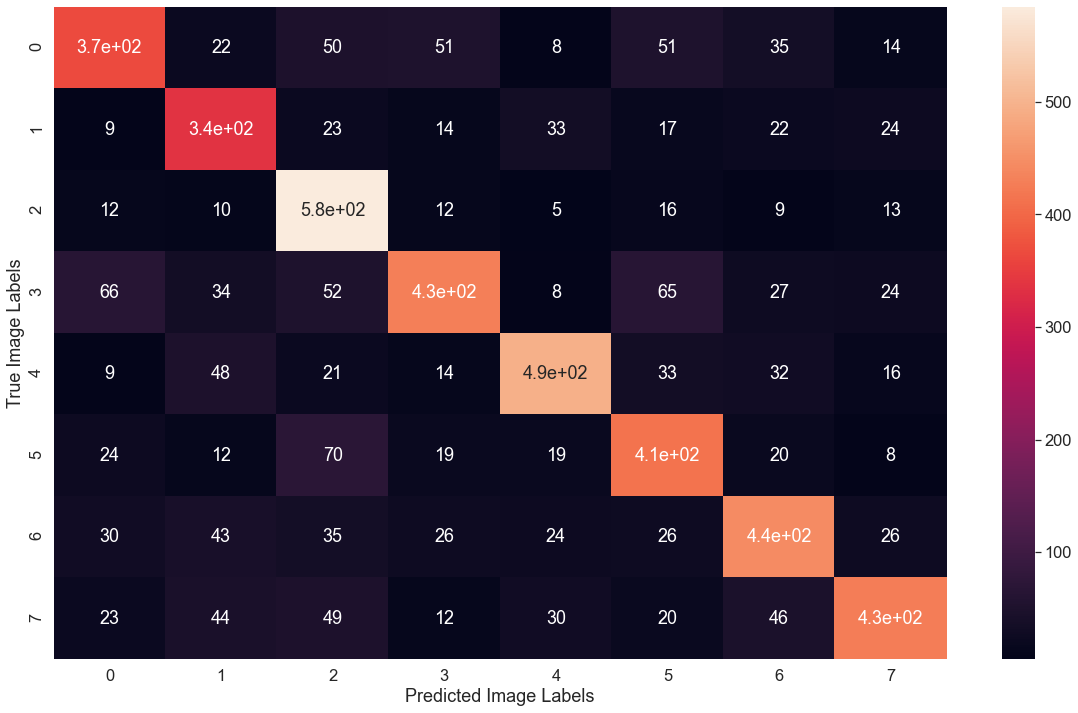

In [30]:
#we plot the confusion matrix using seaborn with annotations =true so that we also see the numbers
size_of_confusion_matrix=(20,12)
seaborn.set(font_scale=1.5)
confusion_plot=pyplot.figure(figsize = size_of_confusion_matrix)

c_plot_axis=seaborn.heatmap(c_matrix,annot=True)
c_plot_axis.set(xlabel='Predicted Image Labels', ylabel='True Image Labels')


In [17]:
#we try to see what a grouping of the best few epochs would do, we take epochs that are within one percent accuracy of our best epoch

#add all our saved models to a list so we can use the knowledge of all of them
epoch_models=list()
epoch_models.append(load_model('./cnn_stride_010_epoch-48_accuracy-0.7512_validation_accuracy-0.6990_validation_loss-0.890.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-46_accuracy-0.7472_validation_accuracy-0.6978_validation_loss-0.889.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-45_accuracy-0.7462_validation_accuracy-0.6966_validation_loss-0.887.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-41_accuracy-0.7416_validation_accuracy-0.6958_validation_loss-0.885.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-36_accuracy-0.7407_validation_accuracy-0.6948_validation_loss-0.879.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-35_accuracy-0.7371_validation_accuracy-0.6930_validation_loss-0.887.h5'))
epoch_models.append(load_model('./cnn_stride_010_epoch-31_accuracy-0.7297_validation_accuracy-0.6916_validation_loss-0.902.h5'))
#fill an array with arrays of predictions based on each model
model_predictions_validation=[]
for epoch_model in epoch_models:
    model_predictions_validation.append(epoch_model.predict(validation_data_flow_conf_matrix))



In [18]:
#take the max out of the predictions of all models
max_predictions_validation = numpy.max(model_predictions_validation, axis=0)
# argmax across classes
prediction_ensamble_validation_max = max_predictions_validation.argmax( axis=1)

#take the max out of the predictions of all models
average_predictions_validation = numpy.average(model_predictions_validation, axis=0)
# argmax across classes
prediction_ensamble_validation_average = average_predictions_validation.argmax( axis=1)

# I don't compute the confusion matrix for this part since using all the last saved epochs was always worse than using just the best epoch
# so I didn't follow this approach

In [19]:
#see what accuracy the max gives us for the combined epochs-> it is worse than the best epoch itself, 69.58%
accuracy_max=sklearn.metrics.accuracy_score(y_true=validation_labels_integers, y_pred=prediction_ensamble_validation_max)
accuracy_max


0.6958

In [20]:
#see what accuracy the average gives us for the combined epochs -> worse then the best epoch itself , 69.6%
accuracy_average=sklearn.metrics.accuracy_score(y_true=validation_labels_integers, y_pred=prediction_ensamble_validation_average)
accuracy_average

0.696

In [21]:
# see if we can combine the best runs of the 3 models we have
#we first load all the saved h5 files into a list-> this was my best submission -> with these models->
#the one that obtained 70.5% on the public leaderboard and 71.175 on the private one
comb_3_models_diff_learningRates=list()
comb_3_models_diff_learningRates.append(load_model('./cnn_64_010_epoch-41_accuracy-0.7242_validation_accuracy-0.6908_validation_loss-0.896.h5'))
comb_3_models_diff_learningRates.append(load_model('./cnn_44_008_epoch-34_accuracy-0.7963_validation_accuracy-0.6882_validation_loss-0.975.h5'))
comb_3_models_diff_learningRates.append(load_model('./cnn_44_005_epoch-32_accuracy-0.8376_validation_accuracy-0.6848_validation_loss-1.062.h5'))

comb_3_models_diff_learningRates.append(load_model('./cnn_stride_010_epoch-45_accuracy-0.7462_validation_accuracy-0.6966_validation_loss-0.887.h5'))
comb_3_models_diff_learningRates.append(load_model('./cnn_stride_015_epoch-49_accuracy-0.7446_validation_accuracy-0.6916_validation_loss-0.901.h5'))
comb_3_models_diff_learningRates.append(load_model('./cnn_stride_005_epoch-54_accuracy-0.7829_validation_accuracy-0.6952_validation_loss-0.930.h5'))

In [22]:
#fill an array with arrays of predictions based on each model
#predict first on validation to see if it brings any improvements
comb_3_models_predictions_validation=[]
for model_variation in comb_3_models_diff_learningRates:
    comb_3_models_predictions_validation.append(model_variation.predict(validation_data_flow_conf_matrix))

In [23]:
#let's use max on the models for 
max_pred_ensamble = numpy.max(comb_3_models_predictions_validation, axis=0)
pred_labels_max = max_pred_ensamble.argmax( axis=1)

#take the average out of the predictions of all models
avg_pred_ensamble = numpy.average(comb_3_models_predictions_validation, axis=0)
pred_labels_avg = avg_pred_ensamble.argmax( axis=1)

In [24]:
#see what accuracy using the max gave us -> this gave 70.62%
accuracy_max=sklearn.metrics.accuracy_score(y_true=validation_labels_integers, y_pred=pred_labels_max)
accuracy_max


0.7062

In [25]:
#see what accuracy the average gives us -> this gave 71.42 % on the validation
#and this ensemble was my final submission with 71.175% on the private dataset
accuracy_average=sklearn.metrics.accuracy_score(y_true=validation_labels_integers, y_pred=pred_labels_avg)
accuracy_average

0.7142

[Text(0.5, 79.5, 'Predicted Image Labels'),
 Text(151.5, 0.5, 'True Image Labels')]

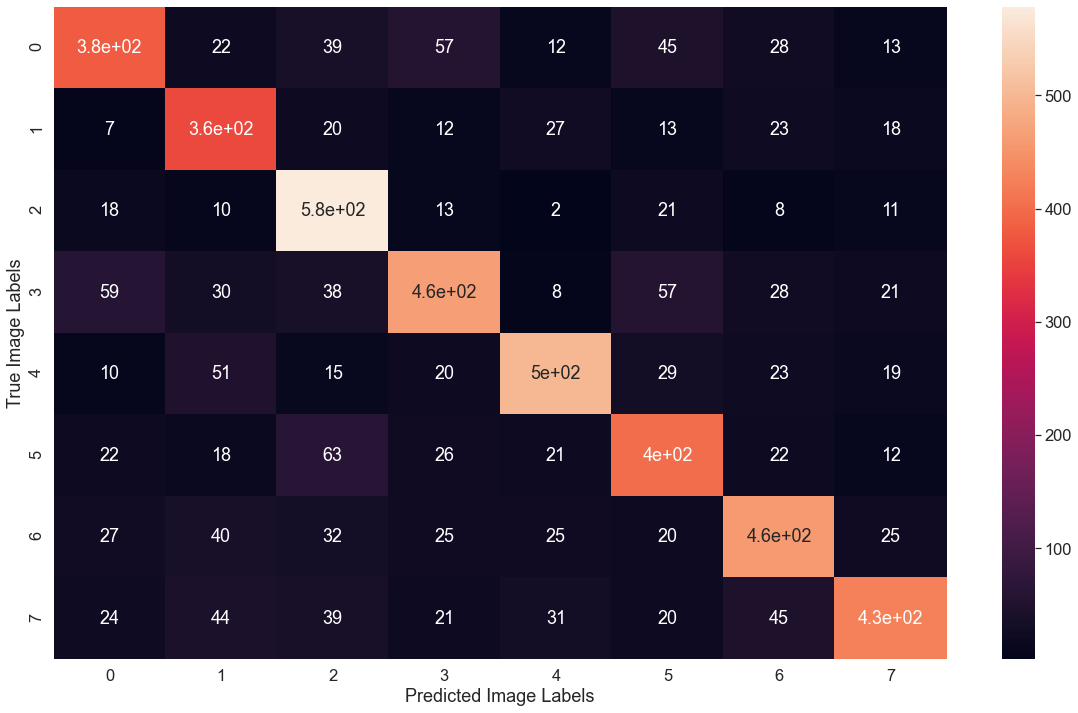

In [32]:
c_matrix_ensemble=sklearn.metrics.confusion_matrix(y_true=validation_labels_integers, y_pred=pred_labels_avg)
#confusion matrix for ensamble of models
confusion_plot=pyplot.figure(figsize = size_of_confusion_matrix)
c_plot_axis_ensemble=seaborn.heatmap(c_matrix_ensemble,annot=True)
c_plot_axis_ensemble.set(xlabel='Predicted Image Labels', ylabel='True Image Labels')

In [27]:
#predict the test results with the average of the models we saved, since it proved better than max on validation
comb_3_models_predictions_test=[]
for model_variation in comb_3_models_diff_learningRates:
    comb_3_models_predictions_test.append(model_variation.predict(test_data_flow))

#take the average of the predictions of all the models
avg_prediction_test_models = numpy.average(comb_3_models_predictions_test, axis=0)
#determine what the label is from the average
pred_labels_avg_test = avg_prediction_test_models.argmax( axis=1)

new_submission_ensamble = open("CNN3Jan_last_submission_ensamble.txt", "w")
new_submission_ensamble.write('id'+','+'label'+'\n')

9

In [28]:
#populate the file I used for my best submission
for line_index,line_content in enumerate(open(os.path.join(base_path,'test.txt'))):
    new_submission_ensamble.write(line_content.rstrip('\n').split(',')[0]+','+str(pred_labels_avg_test[line_index])+'\n')

new_submission_ensamble.close()